In [13]:
"This notebook consist of the own Feed Fordward Neural Network to test on the Wisconsin Breast Cancer dataset. This code dervies from the weekly exercise from week 42, and lecture notes from week 38, 39, 40 and 41."

import autograd.numpy as np
from autograd import grad, elementwise_grad
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

np.random.seed(20)

In [27]:
# defining activations functions, and their derivate. 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    s = sigmoid(z)
    return s * (1 - s)

def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)


# Defining the MSE
def mse(predict, target):
    return np.mean((predict - target) ** 2)

# Defines the binary cross-entropy cost
def binary_cross_entropy(predict, target):
    epsilon = 1e-7
    predict = np.clip(predict, epsilon, 1 - epsilon)  # Clips the predictions to avoid log(0)
    return -np.mean(target* np.log(predict) + (1 - target) * np.log(1 - predict))

# Defines a function to calculate the accuracy
def accuracy(predict, target):
    target_labels = (predict >= 0.5).astype(int)  
    return np.mean(target == target_labels)

In [15]:
# Create layers for batched input
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    # Initialize input size for the first layer
    i_size = network_input_size
    # Iterate through each specified layer output size
    for layer_output_size in layer_output_sizes:
        # Initialize weights (W) with small random values and biases (b) with random values
        W = np.random.randn(i_size, layer_output_size)
        b = np.random.randn(layer_output_size)
        #b = np.zeros(layer_output_size)
        # Append the layer (weights and biases) to the layers list
        layers.append((W, b))

        # Update the input size for the next layer
        i_size = layer_output_size
    return layers

# Create Feed-forward function for batched input
def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs 
    # Iterate through each layer and activation function
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = np.dot(a, W) + b
        a = activation_func(z) # Applying the activation functions
    return a


# Saves the values from the feed-forward function. To be used in the backpropagation. 
def feed_forward_saver_batch(input_batch, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input_batch
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = np.dot(a, W) + b
        a = activation_func(z)
        zs.append(z)

    return layer_inputs, zs, a


# Backpropagation for batched input
def backpropagation_batch(
    input_batch, layers, activation_funcs, targets, activation_ders):
    layer_inputs, zs, predict = feed_forward_saver_batch(input_batch, layers, activation_funcs)
    
    batch_size = input_batch.shape[0]  # Size of the batch
    layer_grads = []  # List to store the gradients in

    error = predict - targets # Iniital differance between predictions and targets

    # Iterate backwards through each layer
    for i in reversed(range(len(layers))):
        layer_input, z = layer_inputs[i], zs[i]

        # Applies the derivate of the activation function except for the last layer
        if i !=len(layers)-1: #To ecxlude the last layer
            error = error * activation_ders[i](z)

        # Calculates the gradients for the weights and biases
        dW = np.dot(layer_input.T, error)/ batch_size
        db = np.mean(error, axis=0)

        # Inserts the gradients
        layer_grads.insert(0, (dW,db))

        # Calculate the error for the next layer
        if i > 0:
            error = np.dot(error, layers[i][0].T)

    return layer_grads


In [ ]:
# Function for training the network
def train_network(inputs, layers, activation_funcs, targets, activation_ders, learning_rate=0.01, epochs=500, batch_size=16, lambda_reg=0.01):
    targets = targets.reshape(-1,1)
    n = len(inputs)

    for epoch in range(epochs):
        indices = np.random.permutation(n)
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]

        for i in range(0, n, batch_size):
            batch_inputs = inputs_shuffled[i:i+batch_size]
            batch_targets = targets_shuffled[i:i+batch_size]

            predictions = feed_forward_batch(batch_inputs, layers, activation_funcs)
            loss = binary_cross_entropy(predictions, batch_targets)

            layer_grads = backpropagation_batch(batch_inputs, layers, activation_funcs, batch_targets, activation_ders)

            for j, ((W,b), (dW, db)) in enumerate(zip(layers, layer_grads)):
                # Adding L2-regulation
                W_update = learning_rate * (dW + lambda_reg * W)
                b_update = learning_rate * db
                layers[j] = (W - W_update, b - b_update)
            
# Function for making predictions            
def predict(inputs, layers, activation_funcs):
    return feed_forward_batch(inputs, layers, activation_funcs)

In [22]:
np.random.seed(20)

# Code for k-fold cross-validation
def cross_validate_model(inputs, targets, network_input_size, layer_output_sizes, activation_funcs, activation_ders, k=5, learning_rate=0.01, epochs=500, batch_size=16, lambda_reg=0.01):
    kf = KFold(n_splits=k, shuffle=True, random_state=20)
    mse_scores = []
    accuracy_scores = []

    # Iterate through each fold
    for train_index, val_index in kf.split(inputs):
        # Split data into training and validation sets
        x_train, x_val = inputs[train_index], inputs[val_index]
        y_train, y_val = targets[train_index], targets[val_index]

        # Reinitialize the network for each fold
        layers = create_layers_batch(network_input_size, layer_output_sizes)

        # Train the model on the training set
        train_network(
            x_train, layers, activation_funcs, y_train, activation_ders,
            learning_rate, epochs, batch_size, lambda_reg
        )

        # Make predictions on the validation set
        y_val_pred_scaled = predict(x_val, layers, activation_funcs)
        y_val_pred_prob = (y_val_pred_scaled >= 0.5).astype(int)

        # Calculate MSE for the validation set
        mse_score = mse(y_val, y_val_pred_scaled)
        mse_scores.append(mse_score)

        # Calculate accuracy for the validation set
        accuracy_score_fold = accuracy_score(y_val, y_val_pred_prob)
        accuracy_scores.append(accuracy_score_fold)

        print(f"MSE for fold: {mse_score:.4f}, Accuracy for fold: {accuracy_score_fold:.4f}")

    # Calculate the average MSE and accuracy over all folds
    avg_mse = np.mean(mse_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"Average MSE over {k} folds: {avg_mse:.4f}")
    print(f"Average Accuracy over {k} folds: {avg_accuracy:.4f}")

    return avg_mse, avg_accuracy

In [23]:
np.random.seed(20)

# Loading the data
data = load_breast_cancer()
X, y = data.data, data.target

# Splits the data in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scales the data using scikit-learn StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Sigmoid activation function and network size [10,10,1]

In [24]:
# Defines det network size
network_input_size = X_train_scaled.shape[1]
layer_output_sizes = [10, 10, 1] #Two hidden layers with 10 nodes. 

# Creates the layers
layers = create_layers_batch(network_input_size, layer_output_sizes)


# Sets the sigmoid funciton for the hidden layers
activation_funcs = [sigmoid, sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der]

# Train the network, defines learning rate, batch size and epochs. 
train_network(X_train_scaled, layers, activation_funcs, y_train, activation_ders, learning_rate=0.01,epochs=500, batch_size=16, lambda_reg=0.01)

# Make predictions
pred_scaled = predict(X_test_scaled, layers, activation_funcs)
pred_prob = (pred_scaled >= 0.5).astype(int)

# Calculates accuracy using scikit-learn accuracy_score
accuracy = accuracy_score(y_test, pred_prob)
test_loss = binary_cross_entropy(pred_scaled, y_test.reshape(-1,1))

# Calculating the average MSE and accuracy using k-fold cross-validation
avg_mse, avg_accuracy = cross_validate_model(X_train_scaled, y_train, network_input_size, layer_output_sizes, activation_funcs, activation_ders, k=10, learning_rate=0.01, epochs=500, batch_size=16,lambda_reg=0.01)

print(f"Test Loss: {test_loss:.4f}")
print( f"Accuracy on test: {accuracy:.4f}")
print( f"Accuracy from cross-validation: {avg_accuracy:.4f}")

MSE for fold: 0.3833, Accuracy for fold: 0.9783
MSE for fold: 0.4064, Accuracy for fold: 0.9565
MSE for fold: 0.3515, Accuracy for fold: 0.9783
MSE for fold: 0.3936, Accuracy for fold: 0.9565
MSE for fold: 0.3809, Accuracy for fold: 0.9783
MSE for fold: 0.3940, Accuracy for fold: 1.0000
MSE for fold: 0.4057, Accuracy for fold: 0.9778
MSE for fold: 0.4198, Accuracy for fold: 1.0000
MSE for fold: 0.3812, Accuracy for fold: 0.9556
MSE for fold: 0.3904, Accuracy for fold: 0.9556
Average MSE over 10 folds: 0.3907
Average Accuracy over 10 folds: 0.9737
Test Loss: 0.1421
Accuracy on test: 0.9737
Accuracy from cross-validation: 0.9737


Sigmoid activation function and network size [16,8,4,1]

In [25]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(20)

data = load_breast_cancer()

X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


network_input_size = X_train_scaled.shape[1]
layer_output_sizes = [16, 8, 4, 1] #Three hidden layers 
layers = create_layers_batch(network_input_size, layer_output_sizes)


# Sets the sigmoid funciton for the hidden layers
activation_funcs = [sigmoid, sigmoid, sigmoid,sigmoid]
activation_ders = [sigmoid_der, sigmoid_der,  sigmoid_der,sigmoid_der]

# Train the network, defines learning rate, batch size and epochs. 
train_network(X_train_scaled, layers, activation_funcs, y_train, activation_ders, learning_rate=0.01,epochs=500, batch_size=16,lambda_reg=0.01)


pred_scaled = predict(X_test_scaled, layers, activation_funcs)
pred_prob = (pred_scaled >= 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_prob)
test_loss = binary_cross_entropy(pred_scaled, y_test.reshape(-1,1))


print(f"Test Loss: {test_loss:.4f}")
print( f"Accuracy on test {accuracy:.4f}")

avg_mse, avg_accuracy = cross_validate_model(X_train_scaled, y_train, network_input_size, layer_output_sizes,activation_funcs, activation_ders, k=10, learning_rate=0.01,epochs=500, batch_size=16, lambda_reg=0.01)
print( f"Accuracy from cross-validation: {avg_accuracy:.4f}")

Test Loss: 0.2043
Accuracy on test 0.9649
MSE for fold: 0.3655, Accuracy for fold: 0.9565
MSE for fold: 0.3777, Accuracy for fold: 0.9565
MSE for fold: 0.2998, Accuracy for fold: 0.9783
MSE for fold: 0.3600, Accuracy for fold: 0.9565
MSE for fold: 0.3452, Accuracy for fold: 0.9783
MSE for fold: 0.3566, Accuracy for fold: 1.0000
MSE for fold: 0.3730, Accuracy for fold: 0.9556
MSE for fold: 0.3763, Accuracy for fold: 1.0000
MSE for fold: 0.3583, Accuracy for fold: 0.9556
MSE for fold: 0.3541, Accuracy for fold: 0.9778
Average MSE over 10 folds: 0.3567
Average Accuracy over 10 folds: 0.9715
Accuracy from cross-validation: 0.9715


ReLU and Sigmoid activation function and network size [10,10,1]

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(20)
# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defines the network parameters
network_input_size = X_train_scaled.shape[1]
layer_output_sizes = [10, 10, 1] #Two hidden layers with 10 nodes. 
layers = create_layers_batch(network_input_size, layer_output_sizes)


# Sets the sigmoid funciton for the hidden layers
activation_funcs = [ReLU, ReLU, sigmoid]
activation_ders = [ReLU_der, ReLU_der, sigmoid_der]

# Train the network, defines learning rate, batch size and epochs. 
train_network(X_train_scaled, layers, activation_funcs, y_train, activation_ders, learning_rate=0.01,epochs=500, batch_size=16, lambda_reg=0.01)

# Predictions
pred_scaled = predict(X_test_scaled, layers, activation_funcs)
pred_prob = (pred_scaled >= 0.5).astype(int)

# Calculate accuracy and loss
accuracy = accuracy_score(y_test, pred_prob)
test_loss = binary_cross_entropy(pred_scaled, y_test.reshape(-1,1))


print(f"Test Loss: {test_loss:.4f}")
print( f"Accuracy on test {accuracy:.4f}")

Test Loss: 0.0831
Accuracy on test 0.9825


ReLU and Sigmoid activation function and network size [16,8,4,1]

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(20)

# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defines the network parameters
network_input_size = X_train_scaled.shape[1]
layer_output_sizes = [10, 10, 1] #Two hidden layers with 10 nodes. 
layers = create_layers_batch(network_input_size, layer_output_sizes)


# Sets the sigmoid funciton for the hidden layers
activation_funcs = [ReLU, ReLU, ReLU, sigmoid]
activation_ders = [ReLU_der, ReLU_der, ReLU_der, sigmoid_der]

# Train the network, defines learning rate, batch size and epochs. 
train_network(X_train_scaled, layers, activation_funcs, y_train, activation_ders, learning_rate=0.01,epochs=500, batch_size=16, lambda_reg=0.01)


pred_scaled = predict(X_test_scaled, layers, activation_funcs)
pred_prob = (pred_scaled >= 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_prob)
test_loss = binary_cross_entropy(pred_scaled, y_test.reshape(-1,1))


print(f"Test Loss: {test_loss:.4f}")
print( f"Accuracy on test {accuracy:.4f}")

Epoch 0, Loss: 5.2162
Epoch 100, Loss: 0.0156
Epoch 200, Loss: 0.0337
Epoch 300, Loss: 0.0055
Epoch 400, Loss: 0.0057
Test Loss: 0.0658
Accuracy on test 0.9737


### Comparing to Scikit-learn MLP Classifier

0.18080596010415492


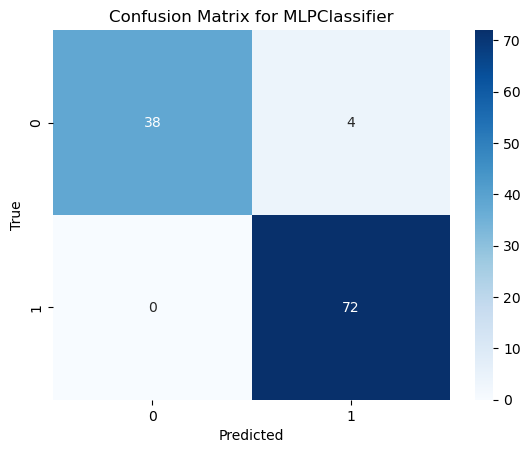

Accuracy using Scikit-learn classifier: 0.9649122807017544
Average accuracy from cross-validation: 0.9736


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss

np.random.seed(20)
# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using the MLP classifiers, defines hyperparameters similiar to own FFNN. 
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', solver='adam', alpha=0.01, batch_size=16,learning_rate_init=0.01, max_iter=500, random_state=20)
mlp_classifier.fit(X_train_scaled, y_train)
mlp_pred_test = mlp_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, mlp_pred_test)
y_test_proba = mlp_classifier.predict_proba(X_test_scaled)
test_loss = log_loss(y_test, y_test_proba)
print(test_loss)

# Create confucion matrix and plot
cm = confusion_matrix(y_test, mlp_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MLPClassifier')
plt.show()

print(f"Accuracy using Scikit-learn classifier: {accuracy}")

scores = cross_val_score(mlp_classifier, X_train_scaled, y_train, cv=5)
print(f"Average accuracy from cross-validation: {np.mean(scores):.4f}")

0.13331567448258388


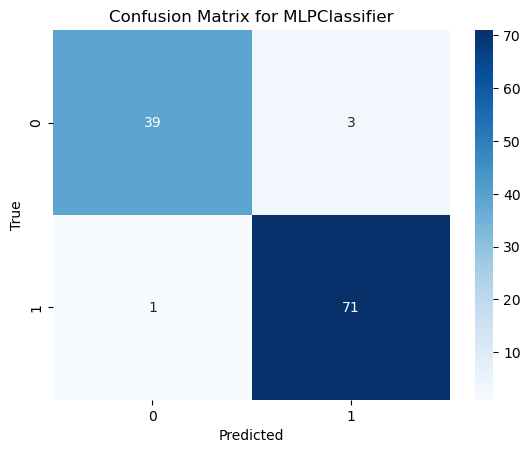

Accuracy using Scikit-learn classifier: 0.9649122807017544
Average accuracy from cross-validation: 0.9692


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss

np.random.seed(20)

# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using the MLP classifiers, defines hyperparameters similiar to own FFNN. 
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10,10), activation='logistic', solver='adam', alpha=0.01, batch_size=16,learning_rate_init=0.01, max_iter=500, random_state=20)
mlp_classifier.fit(X_train_scaled, y_train)
mlp_pred_test = mlp_classifier.predict(X_test_scaled)

# Calculate the accuracy scores
accuracy = accuracy_score(y_test, mlp_pred_test)
y_test_proba = mlp_classifier.predict_proba(X_test_scaled)
test_loss = log_loss(y_test, y_test_proba)
print(test_loss)

# Create confucion matrix and plot
cm = confusion_matrix(y_test, mlp_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MLPClassifier')
plt.show()

print(f"Accuracy using Scikit-learn classifier: {accuracy}")

scores = cross_val_score(mlp_classifier, X_train_scaled, y_train, cv=5)
print(f"Average accuracy from cross-validation: {np.mean(scores):.4f}")